In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [2]:
file = "Entrenamieto_ECI_2020.csv"
data = pd.read_csv(file)
data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [11]:
clear = ["Opportunity_Name", "ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "ASP_converted_Currency", "Product_Name", 
         "Delivery_Year", "Month", "TRF", "Product_Family", "Account_Name", "Submitted_for_Approval", 
         "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", "Total_Amount_Currency", 
         "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"]
min_clear = ["Opportunity_Name", "ID", "Prod_Category_A", "Product_Name", "Account_Name",
             "Delivery_Year", "Month","Product_Family", "Submitted_for_Approval",  "ASP_converted_Currency", 
             "Quote_Type", "Size", "Brand", "Price", "Product_Category_B", "Total_Amount_Currency", 
             "Total_Taxable_Amount_Currency"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [12]:
def preprocess(data):
    
    # elimino caracteres prohibidos
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
    
    rest = [x for x in data.columns if x != 'ID']
    data = data.drop_duplicates(rest)
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    # Contacts: la cantidad de negociaciones registradas
    # Delivery_difference: la cantidad de dias entre las fechas planeadas final e inicial de delivery
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    #data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    #data.loc[data.Concrete_Offer <= 0, "Concrete_Offer"] = 0
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    data["Has_Quote"] = ~(data.Offer_Duration.isna())
    #data.loc[data.Offer_Duration <= 0, "Offer_Duration"] = -1
    data["Same_Owner"] = data.Opportunity_Owner == data.Last_Modified_By
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"  
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (pd.to_datetime(data.Last_Modified_Date) - pd.to_datetime(data.Quote_Expiry_Date)).dt.days
     
    # limpio columnas
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype("category")
    
    data = data.drop(min_clear + dates, axis = 1)
    
    data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)    
    
    return (data)

In [13]:
df = preprocess(data)
categorical = [x for x in df.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage'] + ["TRF"]
#categorical = [x for x in cat_vars if x in df.columns]

parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 30,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 20,
    'learning_rate': 0.015,
    'max_bin': 300,
    'verbose': 0
}

full_data = lgb.Dataset(data = df.drop(target, axis = 1), label = df.Stage, categorical_feature = categorical)
cv_results = lgb.cv(parameters, full_data, num_boost_round = 1000, nfold = 5, early_stopping_rounds = 100)
cv_results["binary_logloss-mean"][-1]

0.07028618176412302

In [ ]:
0.07263988393875857

In [19]:
full_data = lgb.Dataset(data = df.drop(target, axis = 1), label = df.Stage, categorical_feature = categorical)
full_model = lgb.train(parameters, full_data, num_boost_round = 500)

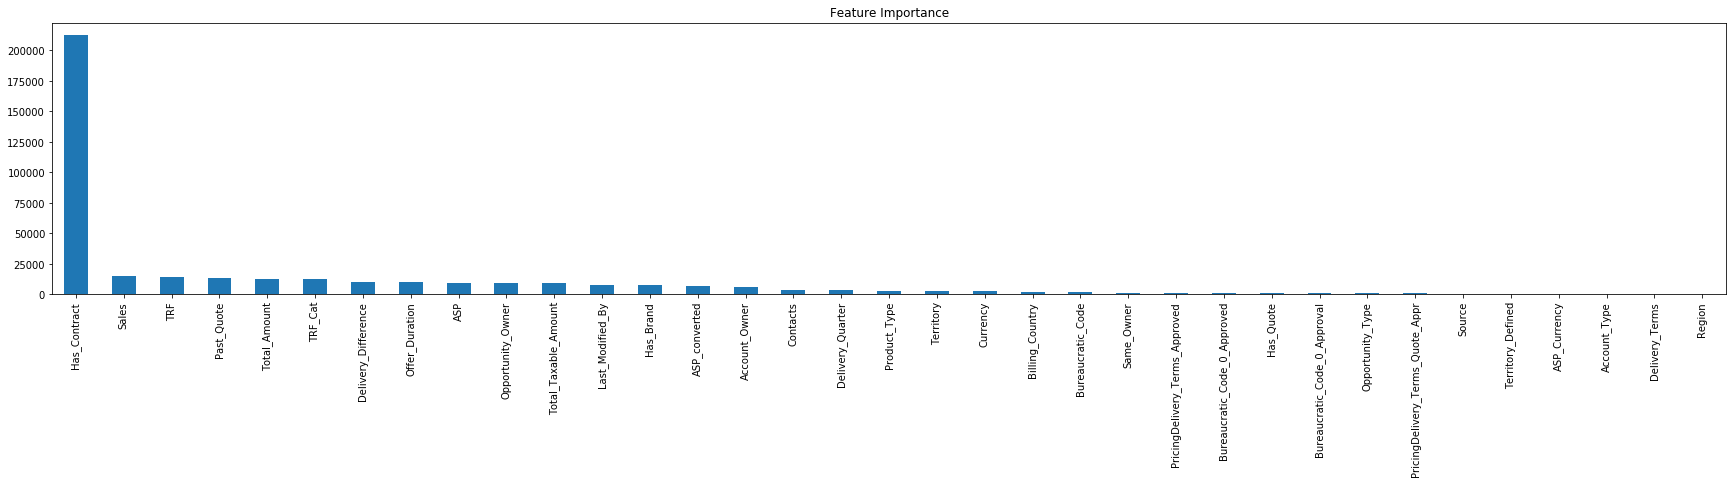

In [16]:
predictors = [x for x in df.drop(target, axis = 1).columns]
feat_imp = pd.Series(full_model.feature_importance("gain"), predictors).sort_values(ascending = False)
#feat_imp = feat_imp[0:30]
plt.rcParams['figure.figsize'] = 30, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [17]:
print feat_imp

Has_Contract                        212321.440498
Sales                                14672.124129
TRF                                  14466.069019
Past_Quote                           13647.543836
Total_Amount                         12750.781227
TRF_Cat                              12291.770500
Delivery_Difference                  10173.041034
Offer_Duration                        9740.198852
ASP                                   8965.870259
Opportunity_Owner                     8916.216233
Total_Taxable_Amount                  8907.570450
Last_Modified_By                      7969.021842
Has_Brand                             7477.151481
ASP_converted                         7160.682994
Account_Owner                         5850.595808
Contacts                              3803.334099
Delivery_Quarter                      3266.931768
Product_Type                          2910.769197
Territory                             2746.445200
Currency                              2652.230163


In [18]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = full_model.predict(validation.drop(leak, axis = 1))

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer2 = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())
prev = pd.read_csv("submission_11.csv")
prev["Prediction"].corr(answer2["Prediction"])

0.9941543809234377

In [20]:
answer2.to_csv("submission_23.csv", header = False, index = False)

In [47]:
from sklearn.model_selection import RandomizedSearchCV

parameters_grid = {
    'application': ['binary'],
    'objective': ['binary'],
    'metric': ['binary_logloss'],
    'boosting_type': ['gbdt', 'dart'],
    'is_unbalance': [False, True],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),      
    'min_child_samples': list(range(20, 100, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'max_bin': list(range(240,400)),
    'feature_fraction': list(np.linspace(0.3, 0.7, 100)),
    'bagging_fraction': list(np.linspace(0.3, 0.7, 100)),
    'bagging_freq': [20],
    'n_estimators': [500]
    #'min_split_gain' : [0.01],    
}

clf = lgb.LGBMClassifier()
grid = RandomizedSearchCV(clf, parameters_grid, verbose = 1, cv = 5, n_jobs = -1, n_iter = 50)
grid.fit(df.drop(target, axis = 1), df.Stage)
#grid = GridSearchCV(clf, parameters_grid, n_jobs = -1, return_train_score = True, cv = 5, refit = True)
#grid.fit(x_train, y_train)
#grid.cv_results_.keys()
#grid.best_params_
#grid.best_score_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 19.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'num_leaves': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, ...7979797979798, 0.6838383838383838, 0.6878787878787879, 0.6919191919191919, 0.6959595959595959, 0.7]},
          pre_dispatc

In [48]:
grid.best_params_

{'application': 'binary',
 'bagging_fraction': 0.44545454545454544,
 'bagging_freq': 20,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.6111111111111112,
 'is_unbalance': False,
 'learning_rate': 0.014772039994401905,
 'max_bin': 295,
 'metric': 'binary_logloss',
 'min_child_samples': 20,
 'n_estimators': 500,
 'num_leaves': 140,
 'objective': 'binary',
 'reg_alpha': 0.8775510204081632,
 'reg_lambda': 0.5918367346938775}

In [100]:
aux = df.groupby("Opportunity_ID", as_index = False).max()

In [40]:
data.Size.value_counts()

None      15903
Other       394
Size_3      356
Size_4      196
Size_1       25
Size_0        7
Size_2        2
Name: Size, dtype: int64